In [1]:
#imports
import pickle 
import nltk
from nltk.tokenize import punkt
from nltk.corpus.reader import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import pyodbc 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};'
                      'SERVER=data-integration-layer.database.windows.net;'
                      'DATABASE=PandoraODS;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

#to test whether connection to database is successful
cursor.execute('SELECT top 5 * FROM ODS_Mendix.Policy')

for row in cursor:
    print(row)

(1, '31806672368305148', datetime.datetime(2016, 9, 14, 2, 4, 31), datetime.datetime(2019, 10, 15, 11, 21, 24), '47-QAA-000153-01', 'Expired', datetime.datetime(2016, 9, 14, 2, 4, 31), datetime.date(2016, 9, 13), datetime.date(2017, 9, 13), False, Decimal('68.00'), Decimal('68.00'), 'Yes', datetime.date(2016, 11, 30), False, '2251799813686268', '2251799813686268', None, '1732', 'maureen mccarthy_47-QAA-000153-01_Policy.pdf', False, True, datetime.date(2017, 6, 10), datetime.date(2017, 5, 16), 'Approved', None, '0', '0', True, 'maureen mccarthy', None, '10 terry lane', None, 'bridgewater', 'MA', '02324', None, True, None, '7599824371190142', None, Decimal('68.00'), None, 'No', False, 'N', datetime.datetime(2020, 5, 15, 6, 37, 37, 638305), datetime.datetime(9999, 12, 31, 23, 59, 59, 999999), 440, None, None, None, None, None, None, None, Decimal('0.0000'), Decimal('0.00'), False, None, None, None, False, Decimal('68.00'), Decimal('0.0000'), False, '123004564822556673')
(2, '3180667236830

In [3]:
#testing to see all drivers
for driver in pyodbc.drivers():
    print(driver)

SQL Server
SQL Server Native Client 11.0
SQL Server Native Client RDA 11.0
ODBC Driver 17 for SQL Server


In [5]:
import pandas as pd

sql_query = pd.read_sql_query("SELECT CAST(Updated_Datetime AS DATE) as Datetime, Cancellation_Sub_Type, Cancellation_Comment FROM ODS_Mendix.Policy where Cancellation_Sub_Type like 'Other' ",conn)
print(sql_query)
print(type(sql_query))

        Datetime Cancellation_Sub_Type  \
0     2020-06-02                 Other   
1     2020-06-02                 Other   
2     2019-10-15                 Other   
3     2020-06-02                 Other   
4     2020-06-02                 Other   
...          ...                   ...   
1088  2020-11-10                 Other   
1089  2020-11-05                 Other   
1090  2020-11-06                 Other   
1091  2020-11-08                 Other   
1092  2020-11-09                 Other   

                                   Cancellation_Comment  
0     Does not need coverage. His wife needed covera...  
1                                                  None  
2                       Need an earlier effective date.  
3            Customer bought the policy for short term.  
4                              No longer employed here.  
...                                                 ...  
1088  Effective date had to be today rewritten 47-QA...  
1089                           

In [8]:
#importing ML model and TF-IDF
path_rfc = "Pickles/best_rfc.pickle"
with open(path_rfc, 'rb') as data:
    best_rfc = pickle.load(data)

path_xtrain = "Pickles/X_train.pickle"
with open(path_xtrain, 'rb') as data:
    X_train = pickle.load(data)
    
path_xtest = "Pickles/X_test.pickle"
with open(path_xtest, 'rb') as data:
    X_test = pickle.load(data)

path_ytrain = "Pickles/y_train.pickle"
with open(path_ytrain, 'rb') as data:
    y_train = pickle.load(data)

path_ytest = "Pickles/y_test.pickle"
with open(path_ytest, 'rb') as data:
    y_test = pickle.load(data)
    
path_features_train = "Pickles/features_train.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)
    
path_labels_train = "Pickles/labels_train.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)
    
path_features_test = "Pickles/features_test.pickle"
with open(path_features_train, 'rb') as data:
    features_train = pickle.load(data)
    
path_labels_test = "Pickles/labels_test.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train = pickle.load(data)
    
path_tfidf = "Pickles/tfidf.pickle"
with open(path_tfidf, 'rb') as data:
    tfidf = pickle.load(data)


In [9]:
category_code = {
    'Change in Coverage Needs': 0, 
    'Major Life Event': 1, 
    'Needed Different Eff Date or Limit': 2,
    'Product Fit': 3,
    'Unknown': 4,
    'Test': 5
}

In [10]:
from nltk.corpus import stopwords

punctuation_signs = list("?:!.,;+&-/<>")
stop_words = list(stopwords.words('english'))

def create_features_from_text(text):
    
    # Dataframe creation
    lemmatized_text_list = []
    df = pd.DataFrame(columns=['Content'])
    df.loc[0] = text
    df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
    df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
    df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
    df['Content_Parsed_3'] = df['Content_Parsed_2']
    for punct_sign in punctuation_signs:
        df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
    df['Content_Parsed_5'] = df['Content_Parsed_4'].fillna("")
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    text = df.loc[0]['Content_Parsed_5']
    text_words = text.split(" ")
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_list)    
    lemmatized_text_list.append(lemmatized_text)
    df['Content_Parsed_6'] = lemmatized_text_list
    df['Content_Parsed_7'] = df['Content_Parsed_6']
    for stop_word in stop_words:
        regex_stopword = r"\b" + stop_word + r"\b"
        df['Content_Parsed_8'] = df['Content_Parsed_7'].str.replace(regex_stopword, '')
    df = df['Content_Parsed_8']

    # TF-IDF
    features = tfidf.transform(df).toarray()
    
    return features

In [11]:
def get_category_name(category_id):
    for category, id_ in category_code.items():    
        if id_ == category_id:
            return category

In [12]:
def predict_from_text(text):
    
    # Predict using the input model
    prediction_rfc = best_rfc.predict(create_features_from_text(text))[0]
    prediction_rfc_proba = best_rfc.predict_proba(create_features_from_text(text))[0]
    
    # Return result:
    category_rfc = get_category_name(prediction_rfc)
    return category_rfc
    
    #print("The predicted category using the Random Forest model is %s." %(category_rfc) )
    #print("The conditional probability is: %a" %(prediction_rfc_proba.max()*100))

In [99]:
sql_query

,Datetime,Cancellation_Sub_Type,Cancellation_Comment
0,2020-06-02,Other,Does not need coverage. His wife needed covera...
1,2020-06-02,Other,None
2,2019-10-15,Other,Need an earlier effective date.
3,2020-06-02,Other,Customer bought the policy for short term.
4,2020-06-02,Other,No longer employed here.
...,...,...,...
1085,2020-10-30,Other,Mistake in enrollment
1086,2020-11-05,Other,Rewrite
1087,2020-11-06,Other,Rewrite to higher limits
1088,2020-11-08,Other,I purchased the policy in error. I do not need...


In [100]:
sql_query['Categorization'] = sql_query['Cancellation_Comment'].apply(predict_from_text)

In [101]:
sql_query

#remember to remove 'None'

,Datetime,Cancellation_Sub_Type,Cancellation_Comment,Categorization
0,2020-06-02,Other,Does not need coverage. His wife needed covera...,Change in Coverage Needs
1,2020-06-02,Other,None,Major Life Event
2,2019-10-15,Other,Need an earlier effective date.,Needed Different Eff Date or Limit
3,2020-06-02,Other,Customer bought the policy for short term.,Change in Coverage Needs
4,2020-06-02,Other,No longer employed here.,Major Life Event
...,...,...,...,...
1085,2020-10-30,Other,Mistake in enrollment,Change in Coverage Needs
1086,2020-11-05,Other,Rewrite,Unknown
1087,2020-11-06,Other,Rewrite to higher limits,Needed Different Eff Date or Limit
1088,2020-11-08,Other,I purchased the policy in error. I do not need...,Change in Coverage Needs


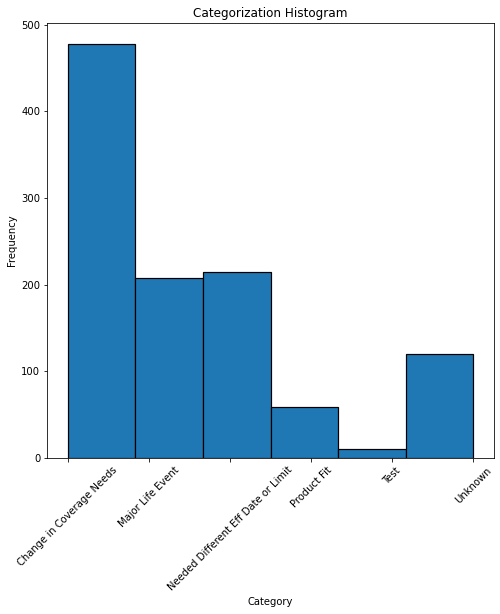

In [102]:
import matplotlib.pyplot as plt
from numpy.random import normal
gaussian_numbers = normal(size=1000)

sql_query = sql_query.sort_values('Categorization')
plt.figure(figsize=(8,8))
plt.hist(sql_query['Categorization'], bins=6, edgecolor='black', linewidth=1.2)
plt.title("Categorization Histogram")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


In [115]:
from datetime import datetime as dt
sql_query['year'] = pd.DatetimeIndex(sql_query['Datetime']).year
sql_query['month'] = pd.DatetimeIndex(sql_query['Datetime']).month
sql_query['new_Datetime'] = pd.to_datetime(sql_query['Datetime']).dt.to_period('M')
sql_query

,Datetime,Cancellation_Sub_Type,Cancellation_Comment,Categorization,year,month,new_Datetime
0,2020-06-02,Other,Does not need coverage. His wife needed covera...,Change in Coverage Needs,2020,6,2020-06
459,2020-06-02,Other,Im not longer practicing at Bienestar Health C...,Change in Coverage Needs,2020,6,2020-06
929,2020-06-10,Other,Does not want the policy for upcoming year. #3...,Change in Coverage Needs,2020,6,2020-06
462,2019-10-15,Other,duplicate policy purchase,Change in Coverage Needs,2019,10,2019-10
463,2020-10-13,Other,Renewal for group cancel,Change in Coverage Needs,2020,10,2020-10
...,...,...,...,...,...,...,...
941,2020-06-17,Other,Ticket # #28418,Unknown,2020,6,2020-06
432,2020-06-02,Other,Rewrite Policy to 1/3MM.,Unknown,2020,6,2020-06
431,2020-10-13,Other,Group Renewal Rewrite complete,Unknown,2020,10,2020-10
460,2019-10-15,Other,"Cancel re-write, classes will be start in July",Unknown,2019,10,2019-10


In [123]:
#export to Excel
sql_query.to_excel("output.xlsx")  

<h2>Re-running trained model on non-Other cancellation comments</h2>

In [7]:
import pandas as pd

sql_query_total = pd.read_sql_query("SELECT CAST(Updated_Datetime AS DATE) as Datetime, Cancellation_Sub_Type, Cancellation_Comment FROM ODS_Mendix.Policy where Cancellation_Sub_Type != 'Other' ",conn)
print(sql_query_total)
print(type(sql_query_total))

        Datetime       Cancellation_Sub_Type  \
0     2020-06-02          Stopped_Practicing   
1     2019-10-15                    Coverage   
2     2020-06-02  Employer_provided_Coverage   
3     2020-06-02    Change_of_Practice_State   
4     2019-10-15  Employer_provided_Coverage   
...          ...                         ...   
1335  2020-10-07         Customer_Experience   
1336  2020-10-10                    Coverage   
1337  2020-10-09                    Coverage   
1338  2020-10-12                    Coverage   
1339  2020-11-02                    Coverage   

                                   Cancellation_Comment  
0                                                  None  
1                                                  None  
2                                                  None  
3                            Only seeing patients in AZ  
4     I do not want to auto renew my policy from las...  
...                                                 ...  
1335  Cancellatio

In [13]:
sql_query_total

,Datetime,Cancellation_Sub_Type,Cancellation_Comment
0,2020-06-02,Stopped_Practicing,None
1,2019-10-15,Coverage,None
2,2020-06-02,Employer_provided_Coverage,None
3,2020-06-02,Change_of_Practice_State,Only seeing patients in AZ
4,2019-10-15,Employer_provided_Coverage,I do not want to auto renew my policy from las...
...,...,...,...
1335,2020-10-07,Customer_Experience,Cancellation requested 10/7/2020. Coverage up ...
1336,2020-10-10,Coverage,I increased coverage and purchased a second po...
1337,2020-10-09,Coverage,Needed $1M/$3M for Walden
1338,2020-10-12,Coverage,Payment and coverage not correct.


In [14]:
sql_query_total['Categorization'] = sql_query_total['Cancellation_Comment'].apply(predict_from_text)

In [15]:
sql_query_total

,Datetime,Cancellation_Sub_Type,Cancellation_Comment,Categorization
0,2020-06-02,Stopped_Practicing,None,Major Life Event
1,2019-10-15,Coverage,None,Major Life Event
2,2020-06-02,Employer_provided_Coverage,None,Major Life Event
3,2020-06-02,Change_of_Practice_State,Only seeing patients in AZ,Change in Coverage Needs
4,2019-10-15,Employer_provided_Coverage,I do not want to auto renew my policy from las...,Change in Coverage Needs
...,...,...,...,...
1335,2020-10-07,Customer_Experience,Cancellation requested 10/7/2020. Coverage up ...,Change in Coverage Needs
1336,2020-10-10,Coverage,I increased coverage and purchased a second po...,Change in Coverage Needs
1337,2020-10-09,Coverage,Needed $1M/$3M for Walden,Needed Different Eff Date or Limit
1338,2020-10-12,Coverage,Payment and coverage not correct.,Major Life Event


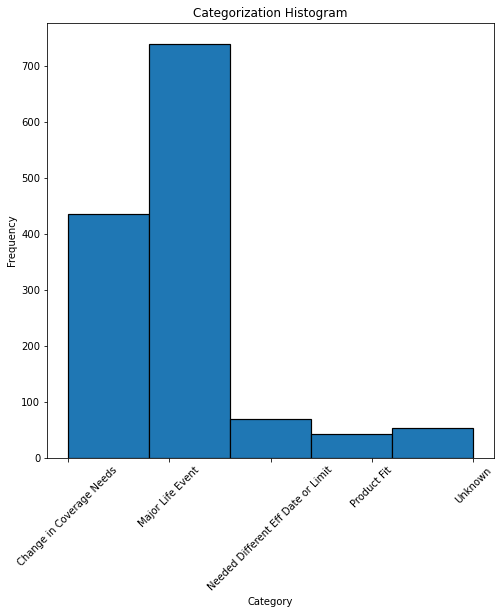

In [17]:
import matplotlib.pyplot as plt
from numpy.random import normal
gaussian_numbers = normal(size=1000)

sql_query_total = sql_query_total.sort_values('Categorization')
plt.figure(figsize=(8,8))
plt.hist(sql_query_total['Categorization'], bins=5, edgecolor='black', linewidth=1.2)
plt.title("Categorization Histogram")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

In [18]:
from datetime import datetime as dt
sql_query_total['year'] = pd.DatetimeIndex(sql_query_total['Datetime']).year
sql_query_total['month'] = pd.DatetimeIndex(sql_query_total['Datetime']).month
sql_query_total['new_Datetime'] = pd.to_datetime(sql_query_total['Datetime']).dt.to_period('M')
sql_query_total

,Datetime,Cancellation_Sub_Type,Cancellation_Comment,Categorization,year,month,new_Datetime
669,2020-05-21,Pricing,found a policy cheaper,Change in Coverage Needs,2020,5,2020-05
21,2020-06-02,Stopped_Practicing,practice has changed,Change in Coverage Needs,2020,6,2020-06
728,2020-01-22,Employer_provided_Coverage,Does not need insurance anymore.,Change in Coverage Needs,2020,1,2020-01
1315,2020-08-25,Coverage,Is looking for group coverage instead. Submitt...,Change in Coverage Needs,2020,8,2020-08
727,2020-08-18,Stopped_Practicing,I have cancer,Change in Coverage Needs,2020,8,2020-08
...,...,...,...,...,...,...,...
1218,2020-04-17,Stopped_Practicing,Clinicals cancelled due to COVID-19.,Unknown,2020,4,2020-04
1114,2020-07-01,Stopped_Practicing,Stopping working at this facility and her empl...,Unknown,2020,7,2020-07
1215,2020-07-29,Stopped_Practicing,Ticket #33139- Stopped working due to COVID,Unknown,2020,7,2020-07
829,2020-02-10,Stopped_Practicing,Rewrote to a Student policy #10457,Unknown,2020,2,2020-02


In [19]:
#export to Excel
sql_query_total.to_excel("output_total.xlsx")  